In [ ]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# 1. Load data
file_path = '/content/delhiaqi.csv'
df = pd.read_csv(file_path, parse_dates=['date'])


In [9]:
# sort by date
df = df.sort_values('date').reset_index(drop=True)

In [10]:
# list of pollutants present
pollutants = ['pm2_5','pm10','so2','no2','co','o3','nh3']

In [11]:
# ensure numeric
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# show head
print(df.head())

                 date       co     no    no2    o3    so2   pm2_5    pm10  \
0 2023-01-01 00:00:00  1655.58   1.66  39.41  5.90  17.88  169.29  194.64   
1 2023-01-01 01:00:00  1869.20   6.82  42.16  1.99  22.17  182.84  211.08   
2 2023-01-01 02:00:00  2510.07  27.72  43.87  0.02  30.04  220.25  260.68   
3 2023-01-01 03:00:00  3150.94  55.43  44.55  0.85  35.76  252.90  304.12   
4 2023-01-01 04:00:00  3471.37  68.84  45.24  5.45  39.10  266.36  322.80   

     nh3  
0   5.83  
1   7.66  
2  11.40  
3  13.55  
4  14.19  


In [12]:
# 2. Define Indian NAQI breakpoints
# Structure: pollutant: list of tuples(lower,upper, index_low, index_high, unit_break_low, unit_break_high)
bp = {
    'pm2_5':  [(0,30,0,50),(31,60,51,100),(61,90,101,200),(91,120,201,300),(121,250,301,400),(251,500,401,500)],
    'pm10':   [(0,50,0,50),(51,100,51,100),(101,250,101,200),(251,350,201,300),(351,430,301,400),(431,1000,401,500)],
    'so2':    [(0,40,0,50),(41,80,51,100),(81,380,101,200),(381,800,201,300),(801,1600,301,400),(1601,10000,401,500)],
    'no2':    [(0,40,0,50),(41,80,51,100),(81,180,101,200),(181,280,201,300),(281,400,301,400),(401,1000,401,500)],
    'co':     [(0,1,0,50),(1.1,2,51,100),(2.1,10,101,200),(10.1,17,201,300),(17.1,34,301,400),(34.1,50,401,500)],
    'o3':     [(0,50,0,50),(51,100,51,100),(101,168,101,200),(169,208,201,300),(209,748,301,400),(749,1000,401,500)],
    'nh3':    [(0,200,0,50),(201,400,51,100),(401,800,101,200),(801,1200,201,300),(1201,1800,301,400),(1801,10000,401,500)]
}

In [13]:
def sub_index(pollutant, value):
    if np.isnan(value):
        return np.nan
    for bp_low, bp_high, idx_low, idx_high in [(r[0],r[1],r[2],r[3]) for r in bp[pollutant]]:
        if bp_low<= value <= bp_high:
            return ((idx_high-idx_low)/(bp_high-bp_low))*(value-bp_low)+idx_low
    return np.nan

In [14]:
# compute subindices
for p in pollutants:
    df[p+'_sub'] = df[p].apply(lambda x: sub_index(p,x))

In [16]:
# overall AQI is max of sub-indices
sub_cols = [p+'_sub' for p in pollutants]
df['AQI'] = df[sub_cols].max(axis=1, skipna=True)
print(df[['date','AQI']].head())


                 date         AQI
0 2023-01-01 00:00:00  338.059767
1 2023-01-01 01:00:00  348.458605
2 2023-01-01 02:00:00  377.168605
3 2023-01-01 03:00:00  401.755422
4 2023-01-01 04:00:00  407.106988


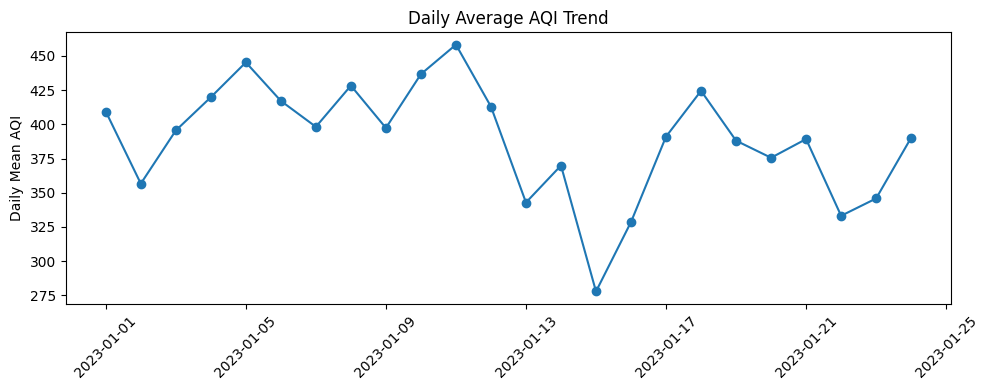

In [17]:
# 3. Visualisations
# Daily average AQI trend
plt.figure(figsize=(10,4))
daily = df.set_index('date')['AQI'].resample('D').mean()
plt.plot(daily.index, daily.values, marker='o')
plt.ylabel('Daily Mean AQI')
plt.title('Daily Average AQI Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

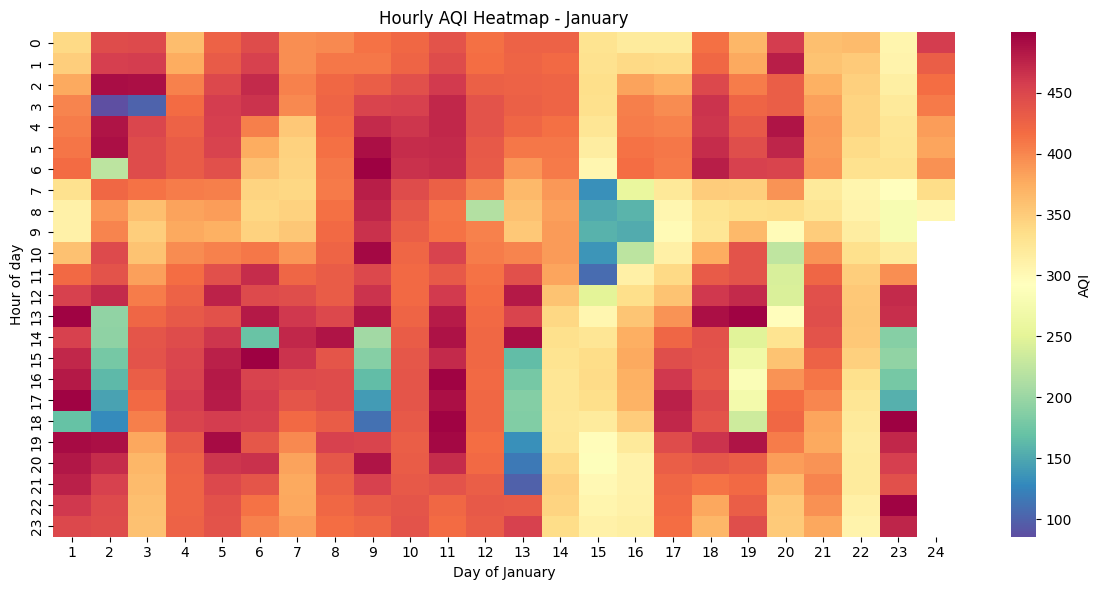

In [18]:
# Heatmap of hourly AQI for first month
jan = df[df['date'].dt.month==1]
jan['day'] = jan['date'].dt.day
jan['hour'] = jan['date'].dt.hour
pivot = jan.pivot_table(index='hour', columns='day', values='AQI')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='Spectral_r', cbar_kws={'label':'AQI'})
plt.title('Hourly AQI Heatmap - January')
plt.ylabel('Hour of day')
plt.xlabel('Day of January')
plt.tight_layout()
plt.show()

In [19]:
# 4. Category assessment
cats = [(0,50,'Good'),(51,100,'Satisfactory'),(101,200,'Moderate'),(201,300,'Poor'),(301,400,'Very Poor'),(401,500,'Severe')]

def cat_fn(aqi):
    for low,high,cat in cats:
        if low<=aqi<=high:
            return cat
    return np.nan

df['Category'] = df['AQI'].apply(cat_fn)
print(df['Category'].value_counts())


Category
Severe          324
Very Poor       183
Moderate         30
Poor             22
Satisfactory      2
Name: count, dtype: int64


In [20]:
# daily categories
daily_cat = daily.apply(cat_fn)
print(daily_cat.value_counts())

AQI
Very Poor    14
Severe        9
Poor          1
Name: count, dtype: int64
